# Detecting Duplicates
In the previous EDA step, we found signs of numerous duplicated tweets. Some of the text strings are exactly identical. These can be dropped using Pandas `drop_duplicates` method. Others are more difficult. Some contain different hashtags and handles. Others have slightly different punctuation.

In this notebook, we'll detect duplicates by measuring the similarity between strings. The basic approach is to clean the text (removing punctuation, stopwords, hashtags and handles), vectorize each string using a word count vectorizer, and measure the cosine angle between vectors. Pairs of sentences with the smallest cosine angle are good candidates for being duplicates.

In [1]:
import pandas as pd
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import numpy as np

stopwords = stopwords.words('english')

Restore the session variables from the DataWranglingEDA step.

In [2]:
import dill
dill.load_session('../session/DataWrangling_EDA.db')

Clean the text to remove punctuation and stopwords

In [3]:
def clean_string(text):
    text = ''.join([character for character in text if character not in string.punctuation])
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stopwords])
    return text

Prepare a CountVectorizer using the vocabulary of the training set. `vectors` is a vectorized version of the text of each tweet.

In [4]:
vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(list(map(clean_string, train.text))).toarray()

Let's compare all of the training tweet vectors to the one already identified as having duplicates by computing the cosine similarity to this string.

In [5]:
test_string = 'Twelve feared killed in Pakistani air ambulance helicopter crash'
test_vec = vectorizer.transform(list(map(clean_string,pd.Series(test_string)))).toarray()
csim = cosine_similarity(test_vec, vectors)

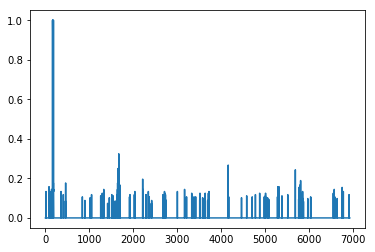

In [6]:
hits = np.amax(csim,0)
plt.plot(hits)

This graph shows that there are a lot of tweets that have non-zero similarity, but the threshold remains low. Let's look at some examples where the threshold is above 0.5.

In [7]:
train.text.iloc[np.greater(hits,0.5)]

172     Twelve feared killed in Pakistani air ambulan...
174    Twelve feared killed in Pakistani air ambulanc...
177    Twelve feared killed in Pakistani air ambulanc...
182     Twelve feared killed in Pakistani air ambulan...
187    Pakistan air ambulance helicopter crash kills ...
203    Twelve feared killed in Pakistani air ambulanc...
Name: text, dtype: object

All of the items with the exception of 175 seem to begin identically to the test string. 175 looks a bit different. Let's have a close look at the entire string.

In [8]:
print(test_string)
print(train.text.iloc[175])

Twelve feared killed in Pakistani air ambulance helicopter crash
Pakistan air ambulance helicopter crash kills nine 


This is an unlikely candidate for a duplicate. It's about a crash that kills nine, not twelve. What's it's cosine similarity score?

In [9]:
hits[175]

0.5345224838248487

This value is just above our threshold of 0.5. Maybe we should select a higher number for the similarity threshold? Let's look at tweets with lower, but non-zero, similarity.

In [10]:
train.text.iloc[np.greater(hits,0.1) & np.less(hits,0.5)]

14        Damage to school bus on 80 in multi car crash  
83       Overturns On  Interstate  Click here if you'v...
85      Carolina accident: Motorcyclist Dies in I-540 ...
100     .  police had previously died in a road accide...
148       mbataweel:   Family members who killed in an...
                              ...                        
7403    Officer Wounded Suspect Killed in Exchange of ...
7405      Richmond police officer wounded suspect killed 
7408    California cops have sketch of gunman who kill...
7433     Officer Wounded Suspect Killed in Exchange of...
7588    BREAKING:  claims responsibility for mosque at...
Name: text, Length: 157, dtype: object

These look like they're definitely not duplicates. Interestingly we see indices 10130 and 10136 look like duplicates.

In the next step, we have to compare each tweet with every other. We can compute the cosine similarity between every pair of tweets. The result is a matrix of similarity scores. 

In [11]:
csim = cosine_similarity(vectors, vectors)